In [1]:
#!/usr/bin/env python
import numpy as np
import xarray as xr
import scipy.interpolate
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker

Some basic helper functions first

In [2]:
def vertinterpolate(var,lev, zlev_int,kind='linear',method=None):
    """Interpolate data unified 0.5 km vertical levels. (except in the first km)

    The default uses numpy interp, but scipy interp1d can also be
    chosen via method="scipy". Scipy interp1d however is much slower. Based on Aiko Voigt's interpolation script."""

    var_int = np.zeros((len(zlev_int)))

    # loop over requested variables
    if method == "scipy":
        f_int = interpolate.interp1d(lev[:], var[:], bounds_error=False, kind=kind, fill_value="nan")
        var_int[:] = f_int(zlev_int)
    else:
        var_int[:] = np.interp(zlev_int[:], lev[:], var[:])

    return var_int

In [3]:
def shift_elements(arr, num, fill_value):
    """"shifting function, with a fill value;
        if just want to "roll it" use np.roll"""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = np.nanargmin(np.abs(array - value))
    return idx

In [5]:
def satvpw(T, param='murphykoop'):
    '''
    calculates saturation vapour pressure over water (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1 = 6.11176750
        a2 = 0.443986062
        a3 = 0.143053301e-01
        a4 = 0.265027242e-03
        a5 = 0.302246994e-05
        a6 = 0.203886313e-07
        a7 = 0.638780966e-10

        esw = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4     \
            + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        # uncertain below -70 C
        Tboil = 373.16
        esw = 10.**(-7.90298*(Tboil/Tk-1.)+ \
              5.02808*np.log10(Tboil/Tk)- \
              1.3816e-7*(10.**(11.344*(1.-Tk/Tboil))-1.)+ \
              8.1328e-3*(10.**(-3.49149*(Tboil/Tk-1.))-1.)+ \
              np.log10(1013.246))

    elif param == 'murphykoop':
        # (good for 123 < T < 332 K)
        esw = np.exp(54.842763 - (6763.22 / Tk) - (4.210 * np.log(Tk)) + \
              (0.000367 * Tk) + (np.tanh(0.0415 * (Tk - 218.8)) * \
              (53.878 - (1331.22 / Tk) - (9.44523 * np.log(Tk)) + \
              0.014025 * Tk))) / 100.

    return esw

def satvpi(T, param='murphykoop'):
    '''
    calculate saturation vapour pressure over ice (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1=6.10952665
        a2=0.501948366
        a3=0.186288989e-01
        a4=0.403488906e-03
        a5=0.539797852e-05
        a6=0.420713632e-07
        a7=0.147271071e-09

        esi = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4       \
             + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        h2otrip = 273.16

        esi = 10.**(-9.09718*(h2otrip/Tk-1.)-3.56654* \
           np.log10(h2otrip/Tk)+0.876793*(1.-Tk/h2otrip)+ \
           np.log10(6.1071)) #*100.

    elif param == 'murphykoop':
        esi = np.exp(9.550426 - (5723.265 / Tk) + (3.53068 * np.log(Tk)) \
                     - (0.00728332 * Tk)) / 100.

    return esi

### Spectral Plume Model, based on Zhou and Xie, 2019 (10.1175/JAS-D-18-0330.1).

The code below was originally written in Matlab by Dennis L. Hartmann (University of Washington), and translated into python by Blaž Gasparini (University of Vienna)

In [6]:
#SPM-specific functions
import aes_thermo_ice2_less as  mt
from scipy import interpolate, optimize
from metpy.interpolate import interpolate_1d
import metpy.calc as mpcalc
from metpy.units import units
#-----------------------

def e_sat(T):

    esl = mt.PvT*(T/mt.T0)**((mt.cpv-mt.cpl)/mt.Rv)*np.exp( ( mt.lv0 - mt.T0*(mt.cpv-mt.cpl) )/mt.Rv * ( 1./mt.T0 - 1./T ) )
    esi = mt.PvT*(T/mt.T0)**((mt.cpv-mt.cpl)/mt.Rv)*np.exp( ( mt.lv0 + mt.lf0 - mt.T0*(mt.cpv-mt.cpl) )/mt.Rv * ( 1./mt.T0 - 1./T ) )
    
    fliq,fice = calc_fice(T)
    
    es = fliq*esl + fice*esi
    
    return es
    
def qq_sat(TK,PPa,qt=None) :

    Psat = e_sat(TK)
        
    rs = mt.Rd/mt.Rv * Psat/(PPa-Psat)
    
    if qt is not None:
        rt = qt/(1-qt)
        qs  = rs / (1+max(rt,rs))
    else:
        qs = rs/(1+rs)
    return qs


def calc_fice(T):

    fliq = (T-mt.T_ice)/(mt.T0-mt.T_ice)
    fliq = np.where(fliq<0,0,fliq)
    fliq = np.where(fliq>1,1,fliq)
    fice = 1-fliq
    return fliq, fice

def calc_saturation(p,T,qt):
    qs = qq_sat(T,p,qt)
    q = np.minimum(qt,qs)
    
    q = np.where(q<0,0,q)
    
    fliq, fice = calc_fice(T)
    
    ql = fliq*(qt-q)
    qi = fice*(qt-q)
    
    ql = np.where(qt-qs<0,0,ql)
    qi = np.where(qt-qs<0,0,qi)
    return q,ql,qi

In [7]:
def PlumeModifiedEuler(h0, z, c, RHS):
    """
    Solve the plume model using the modified Euler method.

    Parameters
    ----------
    h0 : float
        The initial value of h at the surface.
    z : array_like
        The altitude values.
    c : array_like
        The entrainment coefficient values.
    RHS : array_like
        The right-hand side values.

    Returns
    -------
    array_like
        The solution h as an array of the same shape as `z`.

    Notes
    -----
    The plume model is solved using the modified Euler method, which is a second-order
    method that combines forward Euler and the trapezoidal rule. The modified Euler
    method is more accurate than forward Euler and more efficient than the trapezoidal
    rule.
    """
    # initialize output
    h = np.zeros(len(z))
    # value of h at the surface
    h[0] = h0
    for k in range(1, len(z)):
        # predict the value h(k) using forward Euler
        h_eul = h[k-1] + (z[k]-z[k-1]) * (c[k-1]*h[k-1] + RHS[k-1])
        # Now use the trapezoidal rule to integrate from k-1 to k using h_eul in place of h(k)
        h[k] = h[k-1] + 0.5*(z[k]-z[k-1])*(c[k-1]*h[k-1] + RHS[k-1] + c[k]*h_eul + RHS[k])
    return h

In [8]:
def EPS(Z, params,ztop_conv):
    """
    Determine the entrainment profile.

    Parameters
    ----------
    Z : array_like
        The altitude values in meters.
    params : dict
        A dictionary containing the entrainment parameters.
        The dictionary should have the following keys:
        - 'ent': the entrainment coefficient in km^-1
        - 'entexp': the entrainment exponent
        - 'zb': the boundary layer height in meters
    ztop_conv : float
        The convective top height in meters.

    Returns
    -------
    array_like
        The entrainment profile as an array of the same shape as `Z`.

    Notes
    -----
    The entrainment profile is calculated as:

    EPS = params["ent"] * ((ztop_conv - Z) / (ztop_conv - params["zb"])) ** params["entexp"]

    The entrainment profile is zero below the boundary layer height `params["zb"]`
    and above the convective top height `ztop_conv`.
    """    
    #global ztop_conv
    # some predefined values: eps0=3.e-4;  # 0.3 km-1
    EPS = params["ent"] * ((ztop_conv - Z) / (ztop_conv - params["zb"])) ** params["entexp"]
    EPS[Z < params["zb"]] = 0.0
    EPS[Z > ztop_conv] = 0.0
    return EPS

In [9]:
def LAM(eps, z, params, ztop_conv):
    """
    Compute Lambda for the spectral plume model.

    Parameters
    ----------
    eps : float
        The entrainment coefficient in km^-1.
    z : array_like
        The altitude values in meters.
    params : dict
        A dictionary containing the plume model parameters.
        The dictionary should have the following keys:
        - 'zb': the boundary layer height in meters
    ztop_conv : float
        The convective top height in meters.

    Returns
    -------
    array_like
        The Lambda values as an array of the same shape as `z`.

    Notes
    -----
    The Lambda values are computed for the spectral plume model using the following formula:

    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))

    The Lambda values are zero below the boundary layer height `params["zb"]`
    and above the convective top height `ztop_conv`. The Lambda values are also
    clipped to a minimum value of -2e-2.

    The spectral plume model is defined by the following differential equation:

    dH/dt = Lambda * H

    where H is the plume height and Lambda is the entrainment rate.
    """
    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))
    lam[np.isnan(lam)] = 0.0
    lam[z < params["zb"]] = 0.0
    lam[z > ztop_conv] = 0.0
    lam = np.maximum(lam, -2e-2)
    return lam    

    # Comput Lambda for spectral plume model
    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))
    lam[np.isnan(lam)] = 0.0
    lam[z < params["zb"]] = 0.0
    lam[z > ztop_conv] = 0.0
    lam = np.maximum(lam, -2e-2)
    return lam

In [10]:
def RHS(T, p, ent, params,rh_profile):
    """
    Compute the right-hand side of the spectral plume model.

    Parameters
    ----------
    T : array_like
        The temperature values in Kelvin.
    p : array_like
        The pressure values in Pa.
    ent : float
        The entrainment coefficient in km^-1.
    params : dict
        A dictionary containing the plume model parameters.
        The dictionary should have the following keys:
        - 'Eice': a flag indicating whether ice is present (1) or not (0)
    rh_profile : array_like
        The relative humidity profile.

    Returns
    -------
    array_like
        The right-hand side values as an array of the same shape as `T`.
    """
    # Pseudo moist adiabatic lapse rate calculator with entrainment E

    # Use Peter Blossey's script for constants and evaluation of ws
    g = 9.8
    Cp = 1005
    Rd = 287
    L = 2.5e6
    Ls = 3.34e5

    Eice=1
    # set water vapor amount based on RH profile
    if Eice == 1:
        rhs = -L * ent * (1 - rh_profile) * qq_sat(T,p) / Cp  # blended saturation
    else:
        #only liquid - modify it, dont have qsw_mk2005
        rhs = -L * ent * (1 - rh_profile) * qsw_mk2005(p, T) / Cp  # Liquid Saturation

    return rhs

In [11]:
#This code defines a Python class called "DefaultRCEParams". The class has a constructor method __init__() 
#which gets called automatically when an object of this class is created. 
#The constructor method initializes the object with a set of attributes

class DefaultRCEParams:
    def __init__(self):
        self.lapse1 = 5.0
        self.Psfc = 1013e2 # surface pressure in Pa
        self.ent = 3.0e-4 # Entrainment parameter for Spectral Plume Model
        self.entexp = 1.0
        self.zt = 16000.
        self.zb = 1000.

In [12]:
def calculate_DeltaT(z,Tatm,pres,ztop_conv, zb, ent, entexp):
    """
    Calculate the temperature difference between the plume and the environment.

    Parameters
    ----------
    z : array_like
        The altitude values in meters.
    Tatm : array_like
        The atmospheric temperature values in Kelvin.
    pres : array_like
        The atmospheric pressure values in hPa.
    ztop_conv : float
        The convective top height in meters.
    zb : float
        The boundary layer height in meters.
    ent : float
        The entrainment coefficient in km^-1.
    entexp : float
        The entrainment exponent.

    Returns
    -------
    array_like
        The temperature difference values as an array of the same shape as `z`.

    Notes
    -----
    The temperature difference values are calculated using the spectral plume model.
    """
    # default profiles - change to sth more meaningful!
    # z = np.arange(0, 20001, 100)
    #z = moistadi_100_305[0]
    levs = len(z)
    rh = np.ones(levs) * 0.8
    rh_profile = rh.T

    pres = pres * 100
    L = 2.5e6
    Cp = 1004
    Rv = 461
    g = 9.81
    h0 = 0

    qt = np.ones(levs)*0.

    params = {
        'zb': zb,
        'ent': ent,
        'entexp': entexp
    }

    eps1 = EPS(z, params,ztop_conv)
    lam1 = LAM(eps1, z, params,ztop_conv)
    rhs1 = RHS(Tatm, pres, eps1, params,rh_profile)
    h_plume = PlumeModifiedEuler(h0, z, lam1, rhs1)

    cnstt = (L * L) / (Rv * Cp)
    bigfac = 1.0 + cnstt * qq_sat(Tatm, pres) / (Tatm * Tatm)
    deltaT = h_plume / bigfac
    
    plt.plot(deltaT,z)

    return deltaT

In [13]:
#----------------------------------------------------------------------------------------
def dry_moistad_wice_wSPM(T_0=293.15,p_0=1000.,fstop=0.2,zstop=40000.,dz=50.,rh_factor=1.,zstop_dry=500.,ztop_conv=11000, zb=600, ent=3e-4, entexp=1.0):
    '''simulates pressure, temperature and humidity of an air parcel 
       during a moist adiabatic ascent starting at T_0 (K) and p_0 (hPa)
       stopping when f = fstop
       discretised with height steps of dz (m)
    '''

    g = 9.81         # gravitational acceleration
    cp = 1005.       # specific heat of dry air
    #Hv = 2257000.    # heat of vaporisation of water
    Hv = 2501000.    # from wiki and metpy
    Rd = 287.        # specific gas constant of dry air
    lamb = 0.004     # supersaturation tuning parameter => isotopes
    Tmmin = 238.15 #-35   # minimum temperature for mixed phase clouds
    Tmmax = 263.15 #-20   #273.15   # maximum temperature for mixed phase clouds

    # supersaturation over ice and fr_liq as function of temp ###particularly relevant for isotopes, not for this work!
    T_ice = np.arange(99,Tmmin+0.1,0.1)
    T_liq = np.arange(Tmmax,399,0.1)
    Si_ice = 1. - lamb * (T_ice - Tmmax)
    #Si_ice = satvpi(alltemp)
    Si_liq = satvpw(T_liq)/satvpi(T_liq)
    Si_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((Si_ice,Si_liq)),k=2) #quadratic interpolation
    fr_liq_ice = np.zeros(len(T_ice))
    fr_liq_liq = np.ones(len(T_liq))
    fr_liq_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((fr_liq_ice,fr_liq_liq)),k=2) #quadratic interpolation
    #-----------
    
    # initialisation
    T_range = 1. / (Tmmax - Tmmin + 1e-16)
    k = 0
    z1 = 0.
    z = [0.]
    p = [p_0]
    T = [T_0]
    fr_liq = [fr_liq_int(T_0)]
    ewi = [fr_liq[0]*satvpw(T_0) + (1-fr_liq[0])*Si_int(T_0)*satvpi(T_0)] #sat mix pressure over water or ice depending on where we are
    wv = [ rh_factor * 0.622 * ewi[0] / (p_0 - ewi[0])]  #vapor saturation mixing ratio; saturated if rh_factor =1, BG added rh_factor (fixed at 1 for this work)
    q = [wv[0] / (1 + wv[0]) * 1000.]   #??? is this for use with isotopes
    f = 1.
    
    Hvall = [(2.5 * 10**6) - (2.37 * 10**3)*(T_0 - 273.15)]
    Lapse_all = [0.]
    Lapsem_all = [0.]
    Lapsed_all = [0.]
    # dry adiabatic lapse rate
    L_d = g / cp

    #######This is computed only for DRY ADIABATS########################
    while z1 < zstop_dry: 
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # dry adiabatic lapse rate

        T.append(T[k] - L_d*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_d)))

        
        #only water considered for dry adiabat, we are at warm temp
        ewi.append(satvpw(T[k+1],'murphykoop'))
        #ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor;NOT USED in this work! (i.e. set always to 1)
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)
        
        Hvall.append(Hv)
        
        Lapsed_all.append(L_d)

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1        
        
        fr_liq.append(1.0)
        
    ############HERE MOIST ADIABATS######################
    while z1 < zstop:
        z.append(z[k] + dz)
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # moist adiabatic lapse rate
        L_m = L_d * (1 + Hv*wv[k]/(Rd*T[k]))/(1 + Hv**2*wv[k]*0.622/(cp*Rd*T[k]**2))
        Lapsem_all.append(L_m)

        T.append(T[k] - L_m*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_m)))

        #limit fr_liq between 1 and 0
        if (T[k+1]>Tmmax) or (fr_liq_int(T[k+1])>1.):
            fr_liq.append(1.0)
        elif (T[k+1]<Tmmin) or (fr_liq_int(T[k+1])<0.):
            fr_liq.append(0.0)
        else:
            fr_liq.append(fr_liq_int(T[k+1])) 

        #water and ice here
        ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        #only water considered: increases T at anvil level by 1 K or so
        #ewi.append(satvpw(T[k+1],'murphykoop'))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor (not used in this work!)
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)

        Hvall.append(Hv)

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1
    Lapsed_all = np.array(Lapsed_all)
    Lapsem_all = np.array(Lapsem_all)
    Lapse_all = np.array(Lapse_all)
    Lapse_all=np.concatenate((Lapsed_all,Lapsem_all[1:]),axis=0)
    
    #add SPM correction to TEMP ONLY (not to LAPSE RATE!)
    deltaT=calculate_DeltaT(np.array(z),np.array(T),np.array(p),ztop_conv, zb, ent, entexp)

    return np.array(z),np.array(p),np.array(T+deltaT),np.array(deltaT),np.array(ewi),np.array(Lapse_all)#,np.array(Lapsem_all) #np.array(Hvall),np.array(wv/satvpw(T[k]))

In [14]:
#here calculate convective cloud top for different SST values, from 265 to 315 K
#sort of tuning to the values we see in the simulation; but largely using common sense here

start = 8000
step = np.linspace(500, 2000, 10)  # linearly increasing step size between elements
arr = np.cumsum(np.insert(step, 0, 0)) + start

In [15]:
arr_rcemip = arr[6:9] #use only only 295-305 K range for RCEMIP

/tmp/ipykernel_850607/1110380331.py:39: RuntimeWarning: divide by zero encountered in true_divide
  lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))


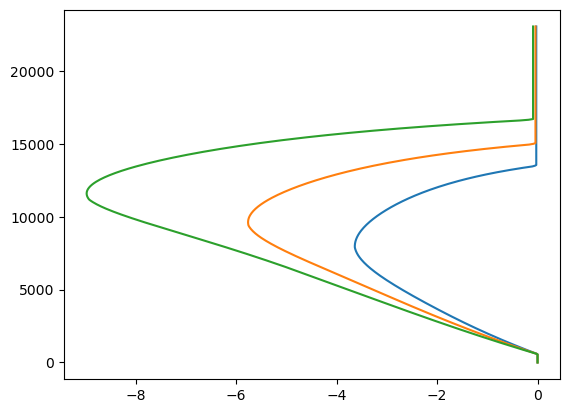

In [16]:
ssts = np.arange(295,305.1,5)
temps = ['295','300','305']
#ztop_sst = np.arange(2000,17000.1,1500)
#ztop_sst= np.arange(2000,20000.1,1800) #BEST w ent = 4e-4
ztop_sst = np.arange(8000,18000.1,1000) #OK, simple to think of it!
##################################
#USING:
ztop_sst = arr_rcemip #np.linspace(500, 2000, 10) #linear ramp BEST !
moistadi_100 = {}
for s,sst in enumerate(ssts):
    moistadi_100[temps[s]] = dry_moistad_wice_wSPM(T_0=sst-2,p_0=1000.,fstop=0.0008,zstop=23000.,dz=50.,rh_factor=1,zstop_dry=600,
                                    ztop_conv=ztop_sst[s], zb=600, ent=4.e-4, entexp=1.0)

1. Latent heat of condensation temp dependent => does make a difference! check again - small!!!???
2. Move from water to ice saturation at some temp => would flatten it, make it cool more in the upper tropo (but maybe 1 K difference only): as it goes in the wrong direction, omitting it here



In [17]:
path = '../../data/RCEMIP_processed/'

ssts = ['295','300','305']
col = ['k','orange','crimson']

variables = ['temperature']
units = ['K/day','K/day','K/day','1','kg/m3','kg/kg']

ds1 = xr.open_dataset(path+'RCElarge_z24_merged_1D_averages_multiplevars2.nc')

Now regrid RCEMIP-simulated profiles to finer vertical levels, 50 m spacing before doing the prediction, using cubic interpolation


In [18]:
# target vertical levels
zlev_int = np.arange(0, 24.001, 0.05) #50 m 
ssts = ['295','300','305']
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
          'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']
variables = ['hr_acre','ice_mixing_ratio','cloud_fraction','density','temperature']

ds1['ice_water_content'] = ds1['ice_mixing_ratio']*ds1['density']

#1.) filter and regrid ACRE 
dataint={}  
data_ice={}
data_temp={}
for v,variable in enumerate(variables):
    dataint[variable]={}
    for m,model in enumerate(models):
        #print(model)
        dataint[variable][model]={}
        data_ice[model]={}
        data_temp[model]={}
        for s,sst in enumerate(ssts):
            dataint[variable][model][sst]={}
            data_ice[model][sst]={}
            data_temp[model][sst]={}
            rho0=ds1['density'][m][s].values
            temp0 = ds1['temperature'][m][s].values
            ice0=ds1['ice_mixing_ratio'][m][s].values*rho0
            alt0=ds1['alt'].values

            plotvar = (ds1[variable][m,s]).values

            if variable=='density':
                pass
            else:
                plotvar[temp0>273] = np.nan
                plotvar[ice0<1e-8] = np.nan

                alt = alt0[~np.isnan(plotvar)]
                plotvar = plotvar[~np.isnan(plotvar)]

            if variable=='density': #we don't want to limit density profiles!
                acre_interp = vertinterpolate(plotvar,alt0,zlev_int,kind='cubic',method='scipy')
            else:
                acre_interp = vertinterpolate(plotvar,alt,zlev_int,kind='cubic',method='scipy')
            if v==0:
                qrad_interp = vertinterpolate(plotvar,alt,zlev_int,kind='cubic',method='scipy')

            #now do the nan to 0 to avoid problems/weird outcomes later when doing subtractions#
            acre_interp = np.nan_to_num(acre_interp, nan=0)

            dataint[variable][model][sst]=acre_interp

In [19]:
temp_anom_best = np.zeros(len(models))
alt_cold = np.zeros(len(models))
temp_cold= np.zeros(len(models))
alt_warm = np.zeros(len(models))
isot_alt_shift = np.zeros(len(models))
isot_alt_shift_adiab = np.zeros(len(models))

dens_cold=np.zeros(len(models))
dens_fac = np.zeros(len(models))

alt_cold_ad = np.zeros(len(models))
alt_warm_ad = np.zeros(len(models))

for m,model in enumerate(models):
    print(m,model)
    alt_cold[m] = np.nanargmax(dataint['hr_acre'][model]['295'])*50 #alt in m (spacing is 50 m)
    temp_cold[m] = dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]

    temp_anom_best[m]= dataint['temperature'][model]['305'][np.nanargmax(dataint['hr_acre'][model]['305'])] - dataint['temperature'][model]['295'][np.nanargmax(dataint['hr_acre'][model]['295'])]

    alt_warm[m] = find_nearest(dataint['temperature'][model]['305'],temp_cold[m]) * 50 #alt in meters
    isot_alt_shift[m] = alt_warm[m] - alt_cold[m]
    #NOTE: moistadi_100_295[2]+deltaT295 = outcome of Spectral Plume Model

    alt_cold_ad[m] = find_nearest(moistadi_100['295'][2],temp_cold[m]) * 50
    alt_warm_ad[m] = find_nearest(moistadi_100['305'][2],temp_cold[m]) * 50
    isot_alt_shift_adiab[m] = alt_warm_ad[m] - alt_cold_ad[m]

0 MESONH
1 NICAM
2 SAM_CRM
3 SAM_GCRM
4 SCALE
5 dam
6 MPAS
7 UCLA-CRM
8 CAM5_GCM
9 CAM6_GCM
10 CNRM-CM6-1
11 GEOS_GCM
12 ICON_LEM_CRM
13 ICON_NWP_CRM
14 SP-CAM
15 SPX-CAM
16 UKMO-GA7.1
17 CM1


In [20]:
###################################
mmm = np.array(['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1'])
idx = [0,1,2,3,4,5,6,7,12,13,17,14,15,16,8,9,10,11]
models = mmm[idx] #turn the order

In [21]:
ph_cold_s3 = np.zeros((len(models),481)) # shifted CRH profile using physical predictive method

densfac_all= np.zeros((len(models),481)) # density factor using physical predictive method
cold_all= np.zeros((len(models),481)) # density factor using physical predictive method
warm_all= np.zeros((len(models),481)) # density factor using physical predictive method

predicted_acre= np.zeros((len(models),481)) # predicted acre profile using isothermal shift and density factor
predicted_acremax=np.zeros(len(models))
predicted_acremax_nodens=np.zeros(len(models))

rms = np.zeros(len(models))
rms_shift_ad = np.zeros(len(models))
rms_densfac_ad = np.zeros(len(models))
rms_dens_iris_ad = np.zeros(len(models))

e_shift_ad = np.zeros(len(models))
e_densfac_ad = np.zeros(len(models))
e_dens_iris_ad = np.zeros(len(models))

rms_all = np.zeros((len(models),2))
e_all = np.zeros((len(models),2))
e_all_expl = np.zeros((len(models),2))

for m,model in enumerate(models):
    #print(m,model)
    cold = dataint['hr_acre'][model]['295']
    cold_all[m,:] = cold
    warm = dataint['hr_acre'][model]['305']
    warm_all[m,:] = warm

    #here done based on physical assumptions of isothermal shift
    index3 = int(isot_alt_shift_adiab[m]/50 )
    ph_cold_s=shift_elements(cold,index3,0) 
    ph_cold_s3[m]=ph_cold_s

    dens_shift3=shift_elements(dataint['density'][model]['295'],index3,0)
    densfac3=dens_shift3/dataint['density'][model]['295'] 
    densfac_all[m,:] = densfac3
    
    #predicted ACRE:
    predicted_acre[m] = ph_cold_s3[m]*densfac_all[m]
    predicted_acremax[m] = np.nanmax(ph_cold_s3[m]*densfac_all[m])
    predicted_acremax_nodens[m] = np.nanmax(ph_cold_s3[m])

/tmp/ipykernel_850607/385657146.py:37: RuntimeWarning: invalid value encountered in true_divide
  densfac3=dens_shift3/dataint['density'][model]['295']


In [23]:
#Define colors of models used later in plot
cols = plt.cm.Spectral(np.linspace(0, 1, len(models)-5))
cols2 = ['deepskyblue','royalblue']
cols3 = plt.cm.Purples(np.linspace(0, 1, len(models)-12))
plt.rcParams.update({'font.size': 16}) #all to 16 if not specified other

SP-CAM
SPX-CAM
13
no gcms
14
no gcms
15
no gcms
16
no gcms
17
no gcms
13
14
15
16
17


Text(0.5, 1.01, 'Peak upper tropospheric CRH')

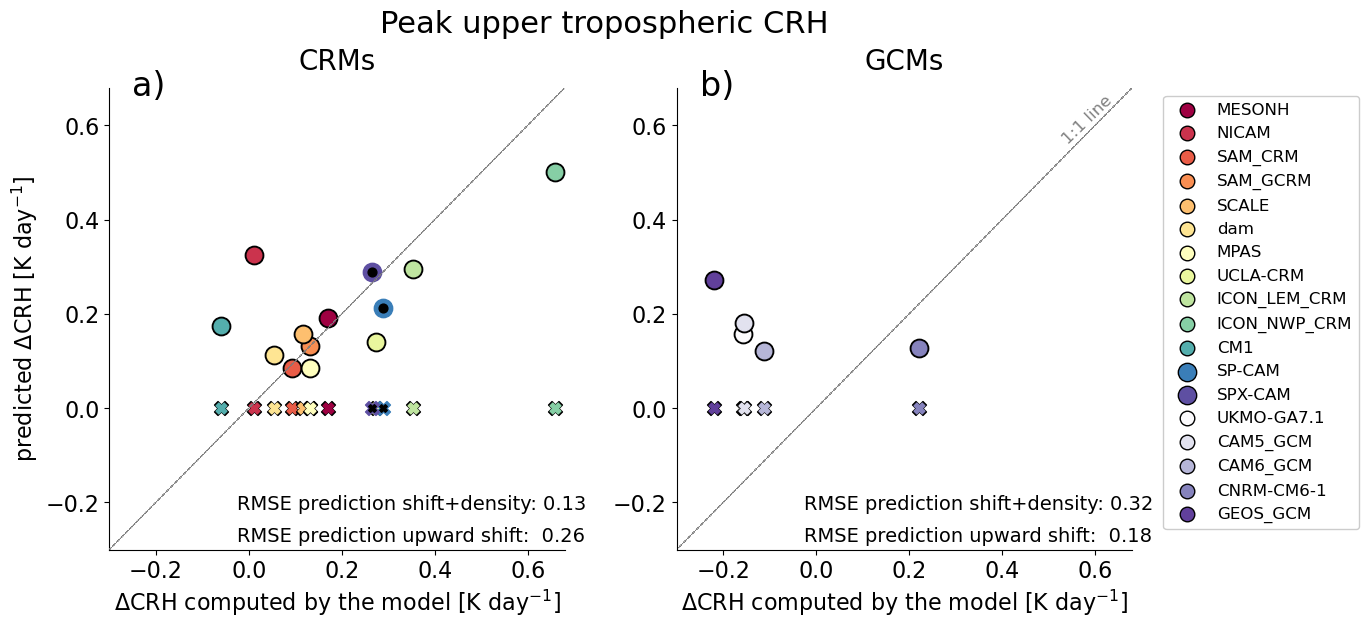

In [27]:
###################################
mmm2 = np.array(['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','DAM','MPAS','UCLA-CRM','CAM5_GCM',
            'CAM6_GCM','CNRM-CM6','GEOS_GCM','ICON_LEM','ICON_NWP','SP-CAM','SPX-CAM','UKMO-GA7','CM1'])
idx = [0,1,2,3,4,5,6,7,12,13,17,14,15,16,8,9,10,11]
models2 = mmm2[idx] #turn the order

b=[]
fig = plt.figure()

fig.set_size_inches(13.2,6,forward=True)
gs = gridspec.GridSpec(1,20,height_ratios=[1],width_ratios=20*[1])

simulated_acremax2 = np.zeros((18))
delta_sim = np.zeros((18))
delta_pred = np.zeros((18))
delta_pred_nod = np.zeros((18))
ax = fig.add_subplot(gs[0,0:9])
for m,model in enumerate(models):
    simulated_acremax  = np.nanmax(warm_all[m])
    simulated_acremax2[m]  = np.nanmax(warm_all[m])
    simulated_acremax  = np.nanmax(warm_all[m])
    simulated_acremax2[m]  = np.nanmax(warm_all[m])
    delta_sim[m] = np.nanmax(warm_all[m])-np.nanmax(cold_all[m,:])
    delta_pred[m] = predicted_acremax[m]-np.nanmax(cold_all[m,:])
    delta_pred_nod[m] = predicted_acremax_nodens[m]-np.nanmax(cold_all[m,:])
    
    if m<11:
        plt.scatter(delta_sim[m], delta_pred[m],color='k',label=model,s=175)
        b.append(plt.scatter(delta_sim[m], delta_pred[m],color=cols[m],label=model,s=110))
        
        plt.scatter(delta_sim[m], delta_pred_nod[m],marker='X',color='k',label=model,s=100)
        plt.scatter(delta_sim[m], delta_pred_nod[m],marker='X',color=cols[m],label=model,s=60)        
    if (m>10) and (m<13):
        print(model)
        b.append(plt.scatter(delta_sim[m], delta_pred[m],color=cols[m],label=model,s=175))
        plt.scatter(delta_sim[m], delta_pred[m],color='k',label=model,s=40)

        plt.scatter(delta_sim[m], delta_pred_nod[m],marker='X',color=cols[m],label=model,s=100)        
        plt.scatter(delta_sim[m], delta_pred_nod[m],marker='X',color='k',label=model,s=30)
         
    if (m>12):
        print(m)
        print('no gcms')

    plt.ylabel('predicted $\Delta$CRH [K day$^{-1}$]')
    plt.xlabel('$\Delta$CRH computed by the model [K day$^{-1}$]')
    plt.plot( [-1.0,1],[-1,1], color='gray',linewidth=0.5,linestyle=':',zorder=999)

    plt.xlim(-0.3,0.68)
    plt.ylim(-0.3,0.68)

plt.title('CRMs',fontsize=20,y=1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(0.05,1.04,'a)',transform=ax.transAxes,horizontalalignment='left',
                 verticalalignment='top',fontsize=24,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1)) 

plt.text(0.28, 0.12, 'RMSE prediction shift+density: 0.13', transform=ax.transAxes, horizontalalignment='left',
         verticalalignment='top', fontsize=14, color='k')
plt.text(0.28, 0.05, 'RMSE prediction upward shift:  0.26', transform=ax.transAxes, horizontalalignment='left',
         verticalalignment='top', fontsize=14, color='k')

ax = fig.add_subplot(gs[0,11:20])
for m,model in enumerate(models):
         
    if (m>12):
        print(m)
        plt.scatter(delta_sim[m], delta_pred[m],marker='o',color='k',label=model,s=175)
        b.append(plt.scatter(delta_sim[m], delta_pred[m],marker='o',label=model,color=cols3[1+m-14],s=110))
        
        plt.scatter(delta_sim[m], delta_pred_nod[m],marker='X',color='k',label=model,s=100)
        plt.scatter(delta_sim[m], delta_pred_nod[m],marker='X',color=cols3[1+m-14],label=model,s=60)        


    plt.xlabel('$\Delta$CRH computed by the model [K day$^{-1}$]')
    plt.plot( [-0.7,0.7],[-0.7,0.7], color='gray',linewidth=0.5,linestyle=':')
    plt.xlim(-0.3,0.68)
    plt.ylim(-0.3,0.68)

plt.title('GCMs',fontsize=20,y=1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(0.84, 0.99, '1:1 line', transform=ax.transAxes, horizontalalignment='left',
         verticalalignment='top', fontsize=12, color='gray', rotation=44)

plt.text(0.28, 0.12, 'RMSE prediction shift+density: 0.32', transform=ax.transAxes, horizontalalignment='left',
         verticalalignment='top', fontsize=14, color='k')
plt.text(0.28, 0.05, 'RMSE prediction upward shift:  0.18', transform=ax.transAxes, horizontalalignment='left',
         verticalalignment='top', fontsize=14, color='k')

plt.text(0.05,1.04,'b)',transform=ax.transAxes,horizontalalignment='left',
                 verticalalignment='top',fontsize=24,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1)) 

legend = plt.legend(b, models, fontsize=12, framealpha=1, bbox_to_anchor=(1.05, 1), loc='upper left')
for lh in legend.legendHandles:
    lh.set_edgecolor('black')

plt.suptitle('Peak upper tropospheric CRH',fontsize=22,y=1.01)

#plt.savefig('/path-to-file/Fig5_RCEMIP_w_prediction.pdf',bbox_inches='tight')

The following two cells calculate the RMSE for CRMs only and for GCMs only using just the vertical shift and the shift+density adjustment

In [28]:
#CRMs
np.sqrt(np.mean((delta_sim[0:13]-delta_pred[0:13])**2)),np.sqrt(np.mean((delta_sim[0:13]-delta_pred_nod[0:13])**2))

#CRMs without mean (just for making sure all is right)
np.sqrt(np.sum((delta_sim[0:13]-delta_pred[0:13])**2)/13),np.sqrt(np.sum((delta_sim[0:13]-delta_pred_nod[0:13])**2)/13)

(0.12794054353515444, 0.2603348469300559)

In [29]:
#GCMs
np.sqrt(np.mean((delta_sim[13:19]-delta_pred[13:19])**2)),np.sqrt(np.mean((delta_sim[13:19]-delta_pred_nod[13:19])**2))

(0.32154430634681225, 0.17807498275068576)